In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
import os.path
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import GRU, Flatten, Dropout, Dense, BatchNormalization, Activation
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import metrics
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline
os.chdir('C:\\Users\\anear\\OneDrive - National University of Ireland, Galway\\PhD\\Research Projects\\Ventilation Project')

Using TensorFlow backend.


In [2]:
# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,37)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=[metrics.AUC()])

# Print model summary
print(model.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 24, 30)            6120      
_________________________________________________________________
flatten_1 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 720)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                28840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
__________________________

In [3]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train = _data['X_6h_train_norm']
reint_train = _data['reint_6h_train']
y_train = _data['y_6h_train']
X_val = _data['X_6h_val_norm']
y_val = _data['y_6h_val']
reint_val = _data['reint_6h_val']
X_test = _data['X_6h_test_norm']
y_test = _data['y_6h_test']
reint_test = _data['reint_6h_test']
print("Loaded!")

Loaded!


In [4]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 8966
No. of patients in train, val, test sets: 7172, 897, 897
No. of extubation failures in train, val, test sets: 2636.0, 325.0, 320.0
Proportion of extubation failures in train, val, test sets: 36.754%, 36.232%, 35.674%


In [5]:
# Remove patients who were re-intubated after 5 days
X_train = X_train[reint_train.astype(int)]
y_train = y_train[reint_train.astype(int)]
X_val = X_val[reint_val.astype(int)]
y_val = y_val[reint_val.astype(int)]
X_test = X_test[reint_test.astype(int)]
y_test = y_test[reint_test.astype(int)]

In [6]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [7]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (7172, 24, 37)
y_train: (7172,)
X_val: (897, 24, 37)
y_val: (897,)
X_test: (897, 24, 37)
y_test: (897,)


In [8]:
# Define the early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=250, batch_size=100, verbose=1, callbacks=[es])


Train on 7172 samples, validate on 897 samples
Epoch 1/250
7172/7172 [==============================] - 2s 214us/step - loss: 0.6903 - auc_1: 0.0000e+00 - val_loss: 0.7535 - val_auc_1: 1.0000
Epoch 2/250
7172/7172 [==============================] - 1s 137us/step - loss: 0.6424 - auc_1: 0.0000e+00 - val_loss: 0.7181 - val_auc_1: 1.0000
Epoch 3/250
7172/7172 [==============================] - 1s 140us/step - loss: 0.6093 - auc_1: 0.0000e+00 - val_loss: 0.6955 - val_auc_1: 1.0000
Epoch 4/250
7172/7172 [==============================] - 1s 146us/step - loss: 0.5784 - auc_1: 0.0000e+00 - val_loss: 0.6848 - val_auc_1: 1.0000
Epoch 5/250
7172/7172 [==============================] - 1s 140us/step - loss: 0.5493 - auc_1: 0.0000e+00 - val_loss: 0.6810 - val_auc_1: 1.0000
Epoch 6/250
7172/7172 [==============================] - 1s 145us/step - loss: 0.5218 - auc_1: 0.0000e+00 - val_loss: 0.6895 - val_auc_1: 1.0000
Epoch 7/250
7172/7172 [==============================] - 1s 144us/step - loss: 0.4

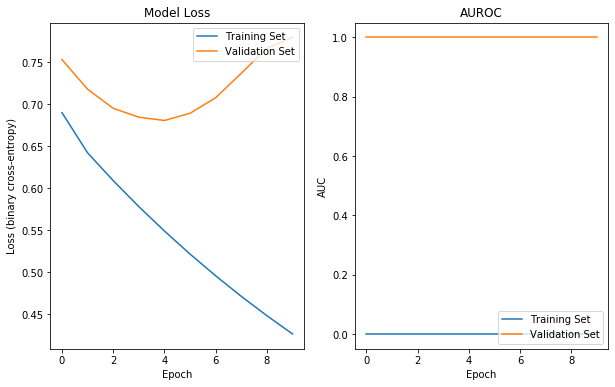

In [9]:
# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(10,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the AUC
ax2.plot(history.history['auc_1'])
ax2.plot(history.history['val_auc_1'])
ax2.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [10]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_6h_rnn = model.predict(X_test).ravel()
fpr_6h_rnn, tpr_6h_rnn, thresholds = roc_curve(y_test, y_pred_6h_rnn)

C:\Users\anear\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [11]:
# Calculate the AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_6h_rnn = auc(fpr_6h_rnn, tpr_6h_rnn)

C:\Users\anear\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


In [12]:
# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,37)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=[metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 24, 30)            6120      
_________________________________________________________________
flatten_2 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 720)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)                28840     
_________________________________________________________________
dropout_4 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
_________________________________________________________________
batch_normalization_2 (Batch (None, 1)                

In [13]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train = _data['X_12h_train_norm']
reint_train = _data['reint_12h_train']
y_train = _data['y_12h_train']
X_val = _data['X_12h_val_norm']
y_val = _data['y_12h_val']
reint_val = _data['reint_12h_val']
X_test = _data['X_12h_test_norm']
y_test = _data['y_12h_test']
reint_test = _data['reint_12h_test']
print("Loaded!")

Loaded!


In [14]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 8966
No. of patients in train, val, test sets: 7172, 897, 897
No. of extubation failures in train, val, test sets: 2636.0, 325.0, 320.0
Proportion of extubation failures in train, val, test sets: 36.754%, 36.232%, 35.674%


In [15]:
# Remove patients who were re-intubated after 5 days
X_train = X_train[reint_train.astype(int)]
y_train = y_train[reint_train.astype(int)]
X_val = X_val[reint_val.astype(int)]
y_val = y_val[reint_val.astype(int)]
X_test = X_test[reint_test.astype(int)]
y_test = y_test[reint_test.astype(int)]

In [16]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [17]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (7172, 24, 37)
y_train: (7172,)
X_val: (897, 24, 37)
y_val: (897,)
X_test: (897, 24, 37)
y_test: (897,)


In [18]:
# Define the early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=250, batch_size=100, verbose=1, callbacks=[es])

Train on 7172 samples, validate on 897 samples
Epoch 1/250
7172/7172 [==============================] - 2s 251us/step - loss: 0.6814 - auc_2: 0.0000e+00 - val_loss: 0.8364 - val_auc_2: 1.0000
Epoch 2/250
7172/7172 [==============================] - 1s 140us/step - loss: 0.6419 - auc_2: 0.0000e+00 - val_loss: 0.6523 - val_auc_2: 1.0000
Epoch 3/250
7172/7172 [==============================] - 1s 148us/step - loss: 0.6093 - auc_2: 0.0000e+00 - val_loss: 0.5077 - val_auc_2: 1.0000
Epoch 4/250
7172/7172 [==============================] - 1s 152us/step - loss: 0.5785 - auc_2: 0.0000e+00 - val_loss: 0.3886 - val_auc_2: 1.0000
Epoch 5/250
7172/7172 [==============================] - 1s 152us/step - loss: 0.5495 - auc_2: 0.0000e+00 - val_loss: 0.2917 - val_auc_2: 1.0000
Epoch 6/250
7172/7172 [==============================] - 1s 146us/step - loss: 0.5220 - auc_2: 0.0000e+00 - val_loss: 0.2058 - val_auc_2: 1.0000
Epoch 7/250
7172/7172 [==============================] - 1s 144us/step - loss: 0.49

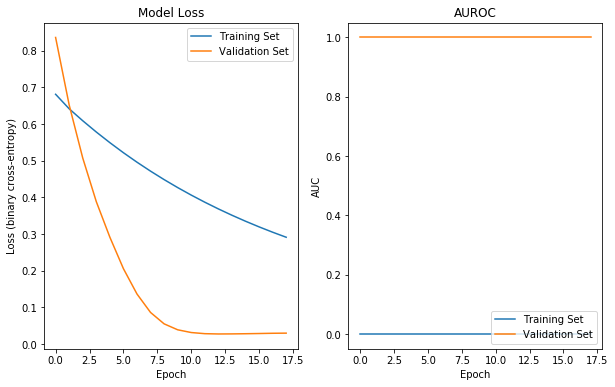

In [19]:
# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(10,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the AUC
ax2.plot(history.history['auc_2'])
ax2.plot(history.history['val_auc_2'])
ax2.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [20]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_12h_rnn = model.predict(X_test).ravel()
fpr_12h_rnn, tpr_12h_rnn, thresholds_12h = roc_curve(y_test, y_pred_12h_rnn)

C:\Users\anear\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [21]:
# Calculate the AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_12h_rnn = auc(fpr_12h_rnn, tpr_12h_rnn)

C:\Users\anear\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


In [22]:
# Define model architecture
model = Sequential()
model.add(GRU(30, return_sequences=True, input_shape=(24,37)))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(40, activation = "sigmoid"))
model.add(Dropout(0.1))
model.add(Dense(1, activation = "sigmoid"))
model.add(BatchNormalization())
model.add((Activation('sigmoid')))

# Compile model
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=[metrics.AUC()])

# Print model summary
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 24, 30)            6120      
_________________________________________________________________
flatten_3 (Flatten)          (None, 720)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 720)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 40)                28840     
_________________________________________________________________
dropout_6 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 41        
_________________________________________________________________
batch_normalization_3 (Batch (None, 1)                

In [23]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train = _data['X_24h_train_norm']
reint_train = _data['reint_24h_train']
y_train = _data['y_24h_train']
X_val = _data['X_24h_val_norm']
y_val = _data['y_24h_val']
reint_val = _data['reint_24h_val']
X_test = _data['X_24h_test_norm']
y_test = _data['y_24h_test']
reint_test = _data['reint_24h_test']
print("Loaded!")

Loaded!


In [24]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

No. of patients: 8966
No. of patients in train, val, test sets: 7172, 897, 897
No. of extubation failures in train, val, test sets: 2636.0, 325.0, 320.0
Proportion of extubation failures in train, val, test sets: 36.754%, 36.232%, 35.674%


In [25]:
# Remove patients who were re-intubated after 5 days
X_train = X_train[reint_train.astype(int)]
y_train = y_train[reint_train.astype(int)]
X_val = X_val[reint_val.astype(int)]
y_val = y_val[reint_val.astype(int)]
X_test = X_test[reint_test.astype(int)]
y_test = y_test[reint_test.astype(int)]

In [26]:
# Reshape the input tensors so they are in the shape (m,T,n) to fit Keras standards
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

In [27]:
# Check the shapes of the arrays
print("X_train: {}".format(np.shape(X_train)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val: {}".format(np.shape(X_val)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test: {}".format(np.shape(X_test)))
print("y_test: {}".format(np.shape(y_test)))

X_train: (7172, 24, 37)
y_train: (7172,)
X_val: (897, 24, 37)
y_val: (897,)
X_test: (897, 24, 37)
y_test: (897,)


In [28]:
# Define the early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=250, batch_size=100, verbose=1, callbacks=[es])

Train on 7172 samples, validate on 897 samples
Epoch 1/250
7172/7172 [==============================] - 2s 237us/step - loss: 0.6810 - auc_3: 0.0000e+00 - val_loss: 1.0140 - val_auc_3: 1.0000
Epoch 2/250
7172/7172 [==============================] - 1s 150us/step - loss: 0.6418 - auc_3: 0.0000e+00 - val_loss: 0.8463 - val_auc_3: 1.0000
Epoch 3/250
1300/7172 [====>.........................] - ETA: 0s - loss: 0.6222 - auc_3: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(10,6))

# PLot the loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set(title='Model Loss', ylabel='Loss (binary cross-entropy)', xlabel='Epoch')
ax1.legend(['Training Set', 'Validation Set'], loc='upper right')

# Plot the AUC
ax2.plot(history.history['auc_3'])
ax2.plot(history.history['val_auc_3'])
ax2.set(title='AUROC', ylabel='AUC', xlabel='Epoch')
ax2.legend(['Training Set', 'Validation Set'], loc='lower right')

#plt.savefig('training.png', bbox_inches='tight')
plt.show()

In [ ]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
y_pred_24h_rnn = model.predict(X_test).ravel()
fpr_24h_rnn, tpr_24h_rnn, thresholds_24h = roc_curve(y_test, y_pred_24h_rnn)

In [ ]:
# Calculate the AUROC for the test set using the RNN
from sklearn.metrics import auc
auc_24h_rnn = auc(fpr_24h_rnn, tpr_24h_rnn)

In [ ]:
# Choose the three thresholds
#thresh_A, thresh_B, thresh_C = 0.8, 0.35, 0.25
#A = np.where(thresholds==thresholds[thresholds>=thresh_A][-1])
#B = np.where(thresholds==thresholds[thresholds>=thresh_B][-1])
#C = np.where(thresholds==thresholds[thresholds>=thresh_C][-1])

# Calculate TP, FP, TN and FN for each threshold
#[[tn_A,fp_A],[fn_A,tp_A]] = confusion_matrix(y_test, y_pred_rnn[:]>thresh_A)
#[[tn_B,fp_B],[fn_B,tp_B]] = confusion_matrix(y_test, y_pred_rnn[:]>thresh_B)
#[[tn_C,fp_C],[fn_C,tp_C]] = confusion_matrix(y_test, y_pred_rnn[:]>thresh_C)

# Plot the ROC curve
#plt.figure(figsize=(8,8))
#plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_rnn, tpr_rnn)
#plt.plot(fpr_rnn[A], tpr_rnn[A],'.', markersize=20, label='A - Acc. = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_A+tn_A)/(tp_A+tn_A+fp_A+fn_A), 100*tp_A/(tp_A+fn_A), 100*tn_A/(tn_A+fp_A), 100*tp_A/(tp_A+fp_A)))
#plt.annotate('A', (fpr_rnn[A]+0.02, tpr_rnn[A]))
#plt.plot(fpr_rnn[B], tpr_rnn[B],'.', markersize=20, label='B - Acc. = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_B+tn_B)/(tp_B+tn_B+fp_B+fn_B), 100*tp_B/(tp_B+fn_B), 100*tn_B/(tn_B+fp_B), 100*tp_B/(tp_B+fp_B)))
#plt.annotate('B', (fpr_rnn[B]-0.03, tpr_rnn[B]))
#plt.plot(fpr_rnn[C], tpr_rnn[C],'.', markersize=20, label='C - Acc. = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_C+tn_C)/(tp_C+tn_C+fp_C+fn_C), 100*tp_C/(tp_C+fn_C), 100*tn_C/(tn_C+fp_C), 100*tp_C/(tp_C+fp_C)))
#plt.annotate('C', (fpr_rnn[C], tpr_rnn[C]-0.04))
#plt.xlabel('1 - (Specificity)')
#plt.ylabel('Sensitivity')
#plt.title('RNN for Predicting Extubation Failure (AUC = {:.3f})'.format(auc_rnn))
#plt.legend(loc='lower right')
#plt.savefig('plots/rnn.png', bbox_inches='tight')
#plt.show()

In [ ]:
# Write a function that plots nice confusion matrices
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm[0][0] = round(cm[0][0],2)
        cm[0][1] = round(cm[0][1],2)
        cm[1][0] = round(cm[1][0],2)
        cm[1][1] = round(cm[1][1],2)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Calculate the confusion matrix
#decision_threshold = thresh_B
#cm = confusion_matrix(y_test, y_pred_rnn[:]>decision_threshold)
#plot_confusion_matrix(cm, ['Success', 'Failure'], normalize=False, title='RNN Model')

In [ ]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train_raw = _data['X_6h_train']
y_train = _data['y_6h_train']
X_val_raw = _data['X_6h_val']
y_val = _data['y_6h_val']
X_test_raw = _data['X_6h_test']
y_test = _data['y_6h_test']
print("Loaded!")

In [ ]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

In [ ]:
# Check the shapes of the arrays
print("X_train_raw: {}".format(np.shape(X_train_raw)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val_raw: {}".format(np.shape(X_val_raw)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test_raw: {}".format(np.shape(X_test_raw)))
print("y_test: {}".format(np.shape(y_test)))

In [ ]:
# Prepare training data for non-temporal models
m, n, T = np.shape(X_train_raw)
X_train_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_train_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_train_static[i,(j*4):(j*4+4)] = extracted_features
        
# Prepare test data for non-temporal models
m, n, T = np.shape(X_test_raw)
X_test_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_test_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_test_static[i,(j*4):(j*4+4)] = extracted_features
        
# Check the shapes of the new arrays
print("X_train_static: {}".format(np.shape(X_train_static)))
print("X_test_static: {}".format(np.shape(X_test_static)))

In [ ]:
# Scale the training data using a z-transform, and apply that scaler to the test data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_static)
X_test_scaled = scaler.transform(X_test_static)
print(np.shape(X_train_scaled))

In [ ]:
# Create logistic regression classifer object
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = "liblinear")

# Train logistic regression classifer
logisticRegr.fit(X_train_scaled, y_train)

# Predict the response for test dataset
y_pred_6h_lr = logisticRegr.predict_proba(X_test_scaled)[:,1]

In [ ]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
fpr_6h_lr, tpr_6h_lr, thresholds_6h_lr = roc_curve(y_test, y_pred_6h_lr)

In [ ]:
# Calculate the AUROC for the test set
from sklearn.metrics import auc
auc_6h_lr = auc(fpr_6h_lr, tpr_6h_lr)

In [ ]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train_raw = _data['X_12h_train']
y_train = _data['y_12h_train']
X_val_raw = _data['X_12h_val']
y_val = _data['y_12h_val']
X_test_raw = _data['X_12h_test']
y_test = _data['y_12h_test']
print("Loaded!")

In [ ]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

In [ ]:
# Check the shapes of the arrays
print("X_train_raw: {}".format(np.shape(X_train_raw)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val_raw: {}".format(np.shape(X_val_raw)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test_raw: {}".format(np.shape(X_test_raw)))
print("y_test: {}".format(np.shape(y_test)))

In [ ]:
# Prepare training data for non-temporal models
m, n, T = np.shape(X_train_raw)
X_train_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_train_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_train_static[i,(j*4):(j*4+4)] = extracted_features
        
# Prepare test data for non-temporal models
m, n, T = np.shape(X_test_raw)
X_test_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_test_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_test_static[i,(j*4):(j*4+4)] = extracted_features
        
# Check the shapes of the new arrays
print("X_train_static: {}".format(np.shape(X_train_static)))
print("X_test_static: {}".format(np.shape(X_test_static)))

In [ ]:
# Scale the training data using a z-transform, and apply that scaler to the test data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_static)
X_test_scaled = scaler.transform(X_test_static)
print(np.shape(X_train_scaled))

In [ ]:
# Create logistic regression classifer object
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = "liblinear")

# Train logistic regression classifer
logisticRegr.fit(X_train_scaled, y_train)

# Predict the response for test dataset
y_pred_12h_lr = logisticRegr.predict_proba(X_test_scaled)[:,1]

In [ ]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
fpr_12h_lr, tpr_12h_lr, thresholds_12h_lr = roc_curve(y_test, y_pred_12h_lr)

In [ ]:
# Calculate the AUROC for the test set
from sklearn.metrics import auc
auc_12h_lr = auc(fpr_12h_lr, tpr_12h_lr)

In [ ]:
# Load the data
_data = np.load('data/ML_data.npy', allow_pickle=True).tolist()
X_train_raw = _data['X_12h_train']
y_train = _data['y_12h_train']
X_val_raw = _data['X_12h_val']
y_val = _data['y_12h_val']
X_test_raw = _data['X_12h_test']
y_test = _data['y_12h_test']
print("Loaded!")

In [ ]:
# Print information about data
print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

In [ ]:
# Check the shapes of the arrays
print("X_train_raw: {}".format(np.shape(X_train_raw)))
print("y_train: {}".format(np.shape(y_train)))
print("X_val_raw: {}".format(np.shape(X_val_raw)))
print("y_val: {}".format(np.shape(y_val)))
print("X_test_raw: {}".format(np.shape(X_test_raw)))
print("y_test: {}".format(np.shape(y_test)))

In [ ]:
# Prepare training data for non-temporal models
m, n, T = np.shape(X_train_raw)
X_train_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_train_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_train_static[i,(j*4):(j*4+4)] = extracted_features
        
# Prepare test data for non-temporal models
m, n, T = np.shape(X_test_raw)
X_test_static = np.zeros((m,n*4))
for i in range(m):
    for j in range(n):
        feature = X_test_raw[i,j,:]
        extracted_features = [np.min(feature), np.max(feature), np.mean(feature), np.std(feature)]
        X_test_static[i,(j*4):(j*4+4)] = extracted_features
        
# Check the shapes of the new arrays
print("X_train_static: {}".format(np.shape(X_train_static)))
print("X_test_static: {}".format(np.shape(X_test_static)))

In [ ]:
# Scale the training data using a z-transform, and apply that scaler to the test data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_static)
X_test_scaled = scaler.transform(X_test_static)
print(np.shape(X_train_scaled))

In [ ]:
# Create logistic regression classifer object
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = "liblinear")

# Train logistic regression classifer
logisticRegr.fit(X_train_scaled, y_train)

# Predict the response for test dataset
y_pred_24h_lr = logisticRegr.predict_proba(X_test_scaled)[:,1]

In [ ]:
# Calculate TPR and FPR on the test set for plotting the ROC curve
from sklearn.metrics import roc_curve
fpr_24h_lr, tpr_24h_lr, thresholds_24h_lr = roc_curve(y_test, y_pred_24h_lr)

In [ ]:
# Calculate the AUROC for the test set
from sklearn.metrics import auc
auc_24h_lr = auc(fpr_24h_lr, tpr_24h_lr)

In [ ]:
# Choose the three thresholds
#thresh_A, thresh_B, thresh_C = 0.8, 0.35, 0.25
#A = np.where(thresholds==thresholds[thresholds>=thresh_A][-1])
#B = np.where(thresholds==thresholds[thresholds>=thresh_B][-1])
#C = np.where(thresholds==thresholds[thresholds>=thresh_C][-1])

# Calculate TP, FP, TN and FN for each threshold
#[[tn_A,fp_A],[fn_A,tp_A]] = confusion_matrix(y_test, y_pred_lr[:]>thresh_A)
#[[tn_B,fp_B],[fn_B,tp_B]] = confusion_matrix(y_test, y_pred_lr[:]>thresh_B)
#[[tn_C,fp_C],[fn_C,tp_C]] = confusion_matrix(y_test, y_pred_lr[:]>thresh_C)

# Plot the ROC curve
#plt.figure(figsize=(8,8))
#plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_lr, tpr_lr)
#plt.plot(fpr_lr[A], tpr_lr[A],'.', markersize=20, label='A - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_A+tn_A)/(tp_A+tn_A+fp_A+fn_A), 100*tp_A/(tp_A+fn_A), 100*tn_A/(tn_A+fp_A), 100*tp_A/(tp_A+fp_A)))
#plt.annotate('A', (fpr_lr[A]+0.02, tpr_lr[A]))
#plt.plot(fpr_lr[B], tpr_lr[B],'.', markersize=20, label='B - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_B+tn_B)/(tp_B+tn_B+fp_B+fn_B), 100*tp_B/(tp_B+fn_B), 100*tn_B/(tn_B+fp_B), 100*tp_B/(tp_B+fp_B)))
#plt.annotate('B', (fpr_lr[B]-0.03, tpr_lr[B]))
#plt.plot(fpr_lr[C], tpr_lr[C],'.', markersize=20, label='C - Accuracy = {:.1f}%, Sens. = {:.1f}%, Spec. = {:.1f}%, PPV = {:.1f}%'.format(100*(tp_C+tn_C)/(tp_C+tn_C+fp_C+fn_C), 100*tp_C/(tp_C+fn_C), 100*tn_C/(tn_C+fp_C), 100*tp_C/(tp_C+fp_C)))
#plt.annotate('C', (fpr_lr[C], tpr_lr[C]-0.04))
#plt.xlabel('1 - (Specificity)')
#plt.ylabel('Sensitivity')
#plt.title('Logistic Regression for Predicting Extubation Failure (AUC = {:.3f})'.format(auc_lr))
#plt.legend(loc='lower right')
#plt.savefig('plots/lr.png', bbox_inches='tight')
#plt.show()

In [ ]:
# Calculate the confusion matrix
#decision_threshold = thresh_B
#cm = confusion_matrix(y_test, y_pred_lr[:]>decision_threshold)
#plot_confusion_matrix(cm, ['Success', 'Failure'], normalize=False, title='Logistic Regression')

In [ ]:
# Create a function to calculate the SAPS II score given some input data
def rsbi(data):
    
    '''
    Function to calculate the RSBI for each patient
    
    INPUTS:
    data - array of shape (m,n,T), where m = number of patients and n = number of features, T = number of time steps
    
    OUTPUTS:
    rsbi - array of shape (m,1), with the calculated RSBI
    '''
    
    # Calculate RSBI
    freq = data[:,25,-1]
    tidvol = data[:,26,-1]/1000
    rsbi = freq/tidvol
    
    # Make prediction
    pred = rsbi > 100
    
    # Return results
    return rsbi, pred

In [ ]:
# Load the data
#_data = np.load('res/ML_data.npy', allow_pickle=True).tolist()
#X_train = _data['X_train']
#y_train = _data['y_train']
#X_val = _data['X_val']
#y_val = _data['y_val']
#X_test = _data['X_test']
#y_test = _data['y_test']
#print("Loaded!")

In [ ]:
# Print information about data
#print("No. of patients: {}".format(len(y_train)+len(y_val)+len(y_test)))
#print("No. of patients in train, val, test sets: {}, {}, {}".format(len(X_train), len(X_val), len(X_test)))
#print("No. of extubation failures in train, val, test sets: {}, {}, {}".format(str(sum(y_train)), str(sum(y_val)), str(sum(y_test))))
#print("Proportion of extubation failures in train, val, test sets: {}%, {}%, {}%".format(round(sum(y_train)/len(y_train)*100,3), round(sum(y_val)/len(y_val)*100,3), round(sum(y_test)/len(y_test)*100,3)))

In [ ]:
# Check the shapes of the arrays
#print("X_train: {}".format(np.shape(X_train)))
#print("y_train: {}".format(np.shape(y_train)))
#print("X_val: {}".format(np.shape(X_val)))
#print("y_val: {}".format(np.shape(y_val)))
#print("X_test: {}".format(np.shape(X_test)))
#print("y_test: {}".format(np.shape(y_test)))

In [ ]:
# Calculate RSBI and make prediction
#rsbi, y_pred_rsbi = rsbi(X_test)

In [ ]:
# Calculate the confusion matrix
#cm = confusion_matrix(y_test, y_pred_rsbi)
#plot_confusion_matrix(cm, ['Success', 'Failure'], normalize=False, title='RSBI')

In [ ]:
# Calculate sensitivity and specificity for RSBI
#[[tn_rsbi,fp_rsbi],[fn_rbsi,tp_rsbi]] = confusion_matrix(y_test, y_pred_rsbi)
#tpr_rsbi = tp_rsbi / (tp_rsbi + fp_rsbi) # TPR = sensitivity
#fpr_rsbi = tp_rsbi / (tp_rsbi + fp_rsbi) # FPR = specificity

In [ ]:
# Compare ROC curves
plt.figure(figsize=(12,12))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_6h_rnn, tpr_6h_rnn, label='6-hour RNN (AUC = {:.3f})'.format(auc_6h_rnn), ls='-')
plt.plot(fpr_12h_rnn, tpr_12h_rnn, label='12-hour RNN (AUC = {:.3f})'.format(auc_12h_rnn), ls='-')
plt.plot(fpr_24h_rnn, tpr_24h_rnn, label='24-hour RNN (AUC = {:.3f})'.format(auc_24h_rnn), ls='-')
plt.plot(fpr_6h_lr, tpr_6h_lr, label='6-hour LR (AUC = {:.3f})'.format(auc_6h_lr), ls='-')
plt.plot(fpr_12h_lr, tpr_12h_lr, label='12-hour LR (AUC = {:.3f})'.format(auc_12h_lr), ls='-')
plt.plot(fpr_24h_lr, tpr_24h_lr, label='24-hour LR (AUC = {:.3f})'.format(auc_24h_lr), ls='-')
#plt.plot(1-fpr_rsbi, tpr_rsbi, '*', markersize=20, c='blue', label='Rapid shallow breathing index > 100 breaths/min/L')
plt.xlabel('1 - (Specificity)')
plt.ylabel('Sensitivity')
plt.title('Predicting Extubation Failure')
plt.legend(loc='lower right')
plt.savefig('plots/roc_curves.png', bbox_inches='tight')
plt.show()